In [ ]:
import re
import collections
from nltk.probability import FreqDist
import nltk
import numpy as np
from matplotlib import pyplot as plt
from nltk import ngrams
from pymystem3 import Mystem
from spacy.lang.ru import Russian
import spacy
from functions import *
import pandas as pd
from tqdm import tqdm

База данных состоит из 12 столбцов:

– id: уникальный номер сообщения в системе twitter;

– tdate: дата публикации сообщения (твита);

– tnamee: имя пользователя, опубликовавшего сообщение;

– ttext:  текст сообщения (твита);

– ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);

– trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;

– trtw: число ретвитов;

– tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;

– tstcount: число всех сообщений пользователя в сети twitter;

– tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);

– tfrien: количество друзей пользователя (те люди, которых читает пользователь);

– listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

Прочитаем данные и построим различные статистики.

In [ ]:
columns_name = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep','trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
positive_dataset = pd.read_csv('positive.csv', sep = ';', names = columns_name)
negative_dataset = pd.read_csv('negative.csv', sep = ';', names = columns_name)

In [ ]:
len(positive_dataset)

114911

In [ ]:
positive_dataset.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Тренировочный корпус состоит из 114,911 положительных, 111,923 отрицательных записей.

Удалим NA

In [ ]:
pos_text = positive_dataset['ttext'].dropna().values
neg_text = negative_dataset['ttext'].dropna().values

In [ ]:
pos_text = regul(r' *http\S* *', pos_text)
pos_text = regul(r' *@\S* ', pos_text)
pos_text = regul(r'RT *', pos_text)
pos_text = regul(r'&quot;', pos_text)
pos_text = regul(r'\n', pos_text)
pos_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', pos_text)
#pos_text = regul(r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+",pos_text) #уберем знаки препинания

In [ ]:
#отделим от слов смайлики и запишем их как один
def split_smile(r,smile, t):
  ans = []
  for i in t:
    ans.append(re.sub(r,smile, i))
  return ans   

In [ ]:
pos_text = split_smile(r'(\w)\)+', r'\1 )', pos_text)

In [ ]:
neg_text = regul(r' *http\S* *', neg_text)
neg_text = regul(r' *@\S* ', neg_text)
neg_text = regul(r'RT *', neg_text)
neg_text = regul(r'&quot;', neg_text)
neg_text = regul(r'\n', neg_text)

neg_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', neg_text)
#neg_text = regul(r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+",neg_text) #уберем знаки препинания
neg_text = split_smile(r'(\w)\(+', r'\1 (', neg_text)

In [ ]:
len_pos = len(pos_text)
len_neg = len(neg_text)

In [ ]:
twits = np.concatenate((pos_text, neg_text))
twits

array([' хоть я и школота  но поверь  у нас то же самое :  общество профилирующий предмет типа )',
       'Да  все-таки он немного похож на него  Но мой мальчик все равно лучше: ',
       ' Ну ты идиотка ) я испугалась за тебя ', ...,
       'Вот и в школу  в говно это идти уже надо (',
       ' Тауриэль  не грусти :( *обнял*',
       'Такси везет меня на работу  Раздумываю приплатить  чтобы меня втащили на пятый этаж  Лифта то нет :('],
      dtype='<U159')

In [ ]:
labels = [1] * len_pos + [0] * len_neg
labels = np.array(labels)
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
#twits = list(filter(None, twits))

In [ ]:
symb_len = [len(i) for i in twits]
word_len = [len(i.split()) for i in twits]

Построим среднее, медиану, стандартное отклонение, минимальное, максимальное значение.

In [ ]:
symb_mean = np.mean(symb_len)
word_mean = np.mean(word_len)
print(symb_mean, word_mean)

68.23689129495578 11.997121242847193


In [ ]:
symb_median = np.median(symb_len)
word_median = np.median(word_len)
print(symb_median, word_median)

63.0 11.0


In [ ]:
symb_std = np.std(symb_len)
word_std = np.std(word_len)
print(symb_std, word_std)

29.100786106000726 5.1585763374296425


In [ ]:
symb_min = np.min(symb_len)
word_min = np.min(word_len)
symb_max = np.max(symb_len)
word_max = np.max(word_len)
print(symb_min, word_min, symb_max, word_max)

2 1 159 36


Построим гистограммы

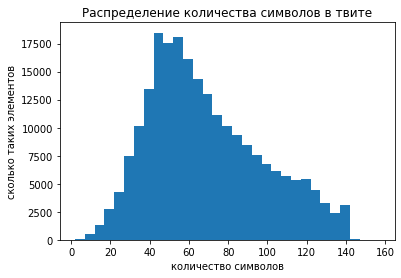

In [ ]:
create_hist(symb_len, np.arange(symb_min, symb_max, 5), 'Распределение количества символов в твите', 'количество символов', 'сколько таких элементов')

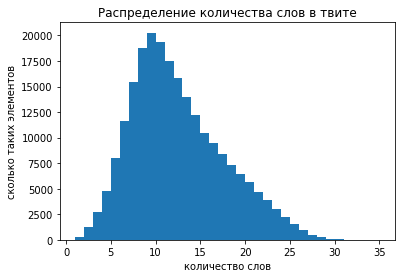

In [ ]:
create_hist(word_len, np.arange(word_min, word_max, 1), 'Распределение количества слов в твите', 'количество слов', 'сколько таких элементов')

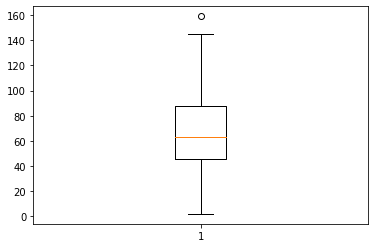

In [ ]:
create_boxplot(symb_len)

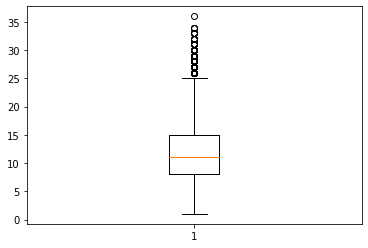

In [ ]:
create_boxplot(word_len)

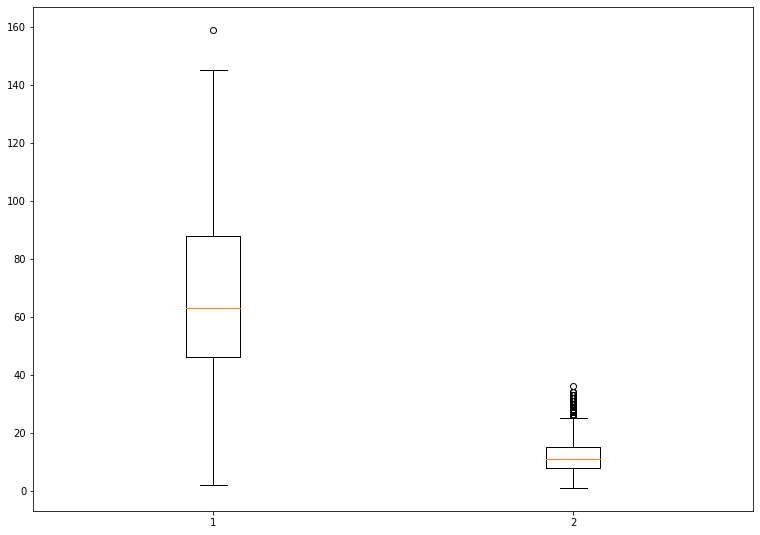

In [ ]:
data = [symb_len, word_len]
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(data)
  
# show plot
plt.show()

In [ ]:
get_ngrams(2, twits, worst=True)

Лучшие 10 2-грамм
[(('у', 'меня'), 8268), (('я', 'не'), 4470), (('а', 'я'), 3705), (('и', 'не'), 3235), (('что', 'я'), 2862), (('не', 'могу'), 2804), (('у', 'нас'), 2318), (('не', 'знаю'), 1992), (('у', 'тебя'), 1601), (('и', 'я'), 1520)]
Худшие 10 2-грамм
[(('Лифта', 'то'), 1), (('этаж', 'Лифта'), 1), (('пятый', 'этаж'), 1), (('на', 'пятый'), 1), (('втащили', 'на'), 1), (('меня', 'втащили'), 1), (('приплатить', 'чтобы'), 1), (('Раздумываю', 'приплатить'), 1), (('работу', 'Раздумываю'), 1), (('Такси', 'везет'), 1)]


In [ ]:
# get_ngrams(3, twits, worst=True)

In [ ]:
get_frequent_words(' '.join(twits), top=10)

[('не', 69370),
 (')', 65535),
 ('и', 55018),
 ('(', 54483),
 ('в', 52888),
 ('я', 52550),
 ('на', 35716),
 ('что', 31491),
 ('а', 26709),
 ('с', 25512)]

In [ ]:
# twits_lem = get_lemmatize(' '.join(twits))

Определим части речи у слов и посмотрим распределение биграмм частей речи

Available trained pipelines for Russian: ru_core_news_sm, ru_core_news_md, ru_core_news_lg

https://spacy.io/models/ru

In [ ]:
#!python -m spacy download ru_core_news_sm

In [ ]:
#!python -m spacy download ru_core_news_lg

In [ ]:
#get_freq_pos(twits, "ru_core_news_lg")# используем обученную модель
# разбить на части и склеить потом

In [ ]:
# ans_pos = get_pos(twits, "ru_core_news_lg")

In [ ]:
# get_ngrams(2, ans_pos, worst=True)

прилагательное (ADJ)

наречие (ADV)

междометие (INTJ)

существительное (NOUN)

фразеологизм (PHRASE)

предикатив (PRE)

имя собственное (PROPN)

глагол (VERB)

вспомогательный глагол (AUX)

союз сочинительный (CCONJ)

детерминатив (DET)

числительное (NUM)

частица (PART)

послелог (ADP)

предлог (ADP)

местоимение (PRON)

союз подчинительный (SCONJ)

пунктуация (PUNCT)

символ (SYM)

другое (X)

# Issue 1: Training of the first sentiment model

In [ ]:
import random
from sklearn.model_selection import train_test_split

In [ ]:
# data = list(zip(twits, labels))
# random.shuffle(data)

# X, y = zip(*data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
X_train

array(['Немного выпьем  говорил он  ничего не будет  говорил он )',
       'я по твоему общению и шуткам соскучилась  Че-то давно не виделись (',
       ' ахахаахх как ты мою собаку уже не называл  ))', ...,
       'дому чуть больше   лет а мне приходится вторую раковину менять ;(',
       '  даже представить боюсь (',
       'через   дней будет месяц как мы не общаемся  мм да уж как время быстро летит ('],
      dtype='<U159')

In [ ]:
#X_train list; здесь токенизируем
X_right = []
for el in X_train:
    X_right.append(el.strip().split())  

In [ ]:
model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)

In [ ]:
model_right.wv.most_similar('уроке', topn=10)

[('физ-ре', 0.8956855535507202),
 ('уроках', 0.8883489370346069),
 ('перемене', 0.879915714263916),
 ('укр', 0.8773329257965088),
 ('контрольную', 0.8639079332351685),
 ('проходим', 0.8625271320343018),
 ('паре', 0.8616552948951721),
 ('самостоятельную', 0.860016942024231),
 ('танцах', 0.8580213785171509),
 ('Учительница', 0.8574640154838562)]

In [ ]:
model_right.wv['улице']

array([ 0.02659396, -0.21479213, -0.5838129 , -0.01427948,  0.3098289 ,
       -0.09860443,  0.6683553 ,  0.17624868, -0.5699238 , -0.6850354 ,
       -0.5846386 ,  0.7942575 , -0.34407356,  0.53469473,  0.14910698,
        0.142934  ,  0.7119737 ,  0.01488933,  1.0393494 , -0.3290772 ,
        0.44176653, -1.1502817 , -0.48028624,  0.01783479,  0.26309302,
        0.561948  , -0.3439081 , -0.3458481 , -1.3591629 ,  0.61437047,
        0.23388295,  0.8347557 ,  0.1749731 , -0.17671809,  1.0055851 ,
        0.4035532 ,  0.12973857, -0.05185575,  0.14419444,  0.43023998,
        0.17006554, -0.8265554 ,  0.02959737,  0.05288721,  0.32981366,
       -0.19299507,  0.01130702,  0.7696313 ,  0.19468246,  0.3066525 ,
        0.17131075,  0.36529404, -0.01019254, -0.03127773, -0.18771806,
       -0.23403208, -0.1262413 , -0.62575716,  0.63603336,  0.05595901,
       -0.0521203 ,  0.31383407,  0.9197134 ,  0.179193  , -0.15492418,
        0.26048315,  0.04717547,  0.85867554,  0.26033524, -0.61

In [ ]:
X_right[0]

['Немного',
 'выпьем',
 'говорил',
 'он',
 'ничего',
 'не',
 'будет',
 'говорил',
 'он',
 ')']

In [ ]:
# посчитаем среднее значение векторов, входящих в твит
X_vec = []

In [ ]:
for i in range(len(X_right)):
    ans = 0
    for j in range(len(X_right[i])):
        ans += model_right.wv[X_right[i][j]]
    X_vec.append(ans/len(X_right[i]))    

Рассмотрим XGBoost

In [ ]:
import xgboost

In [ ]:
model = xgboost.XGBClassifier(n_estimators=200)
model.fit(np.array(X_vec), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [ ]:
#X_test in list
X_right_test = []
for el in X_test:
    X_right_test.append(el.strip().split())

Обучим модель w2v так же на тестовом датасете.

In [ ]:
model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)

(4206328, 5437340)

In [ ]:
model_right.build_vocab(X_right_test, update=True)

In [ ]:
X_vec_test = []

In [ ]:
for i in range(len(X_right_test)):
    ans = 0
    for j in range(len(X_right_test[i])):
        ans += model_right.wv[X_right_test[i][j]]
    X_vec_test.append(ans/len(X_right_test[i])) 

In [ ]:
y_pred = model.predict(np.array(X_vec_test))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# 76.70% с /len(X_right_test[i]) с ! 
# 69.93% без /len(X_right_test[i])
# 77.43% с /len(X_right_test[i]) и без !
# 80.04%
# 86.12%

Accuracy: 86.85%


In [ ]:
#print(roc_auc_score(y_test,y_pred))

0.9491059840338895


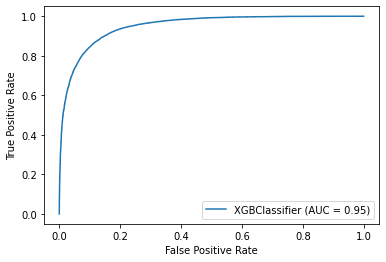

In [ ]:
y_score = model.predict_proba(X_vec_test)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(model, X_vec_test, y_test)  
plt.show()                               

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     22480
           1       0.90      0.83      0.86     22887

    accuracy                           0.87     45367
   macro avg       0.87      0.87      0.87     45367
weighted avg       0.87      0.87      0.87     45367



In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted      0      1
Actual                 
0          20478   2002
1           3964  18923


In [ ]:
import seaborn as sn

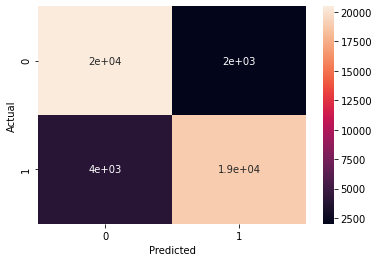

In [ ]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Посмотрим на LIGHTGBM.


In [ ]:
import lightgbm as lgb

In [ ]:
clf = lgb.LGBMClassifier(learning_rate=0.1)
clf.fit(X_vec, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred=clf.predict(X_vec_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 0.7822
# 0.7708
# 0.8611

LightGBM Model accuracy score: 0.8702


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[20260  2220]
 [ 3670 19217]]

True Positives(TP) =  20260

True Negatives(TN) =  19217

False Positives(FP) =  2220

False Negatives(FN) =  3670


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     22480
           1       0.90      0.84      0.87     22887

    accuracy                           0.87     45367
   macro avg       0.87      0.87      0.87     45367
weighted avg       0.87      0.87      0.87     45367



0.9484174268613847


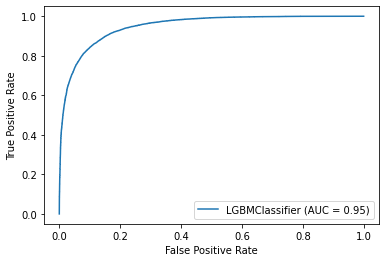

In [ ]:
y_score = clf.predict_proba(X_vec_test)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(clf, X_vec_test, y_test)  
plt.show()  

https://www.kaggle.com/prashant111/lightgbm-classifier-in-python

Рассмотрим модель svm. Тут очень долго все работает.

In [ ]:
from sklearn import svm

In [ ]:
# svclassifier = svm.SVC(kernel='linear')
# svclassifier.fit(X_vec, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# y_pred = svclassifier.predict(X_test)

In [ ]:
# accuracy=accuracy_score(y_pred, y_test)
# print('SVM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

In [ ]:
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))

In [ ]:
#model.train([['potoatoes', 'and', 'farmers']], total_examples=model.corpus_count, epochs=model.epochs)
#model.build_vocab([['potoatoes', 'and', 'farmers']], update=True)

In [ ]:
print(confusion_matrix(y_test,y_pred))

In [ ]:
# !wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

# !ls  ## Check if required cuda 9.0 amd64-deb file is downloaded
# !dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
# !ls /var/cuda-repo-9-0-local | grep .pub
# !apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
# !apt-get update
# !sudo apt-get install cuda-9.0

In [ ]:
#from thundersvm import SVC

In [ ]:
# clf = SVC()
# clf.fit(X_vec, y_train)

In [ ]:
# y_pred = clf.predict(X_vec_test)

w2v в картинках: https://habr.com/ru/post/446530/

In [ ]:
#ПОПРОБУЕМ ЕЩЕ RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=42, n_estimators = 200)
clf.fit(X_vec, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_vec_test)

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
print('Random forest Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Random forest Model accuracy score: 0.7799


In [ ]:
#Напишем нейронную сеть

In [ ]:
import torch
import torchvision
from torchvision import transforms

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]

In [ ]:
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
X_train_net = torch.Tensor(X_vec)
y_train_net = torch.Tensor(y_train_new)

In [ ]:
y_train_net

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [ ]:
net.forward(X_train_net)

tensor([[0.5213, 0.4908],
        [0.5201, 0.4920],
        [0.5210, 0.4900],
        ...,
        [0.5205, 0.4908],
        [0.5193, 0.4901],
        [0.5203, 0.4920]], grad_fn=<SigmoidBackward>)

In [ ]:
# trainset = torch.utils.data.DataLoader(X_vec, batch_size=10, shuffle=True)
# testset = torch.utils.data.DataLoader(X_vec_test, batch_size=10, shuffle=False)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30

for epoch in range(EPOCHS):
     
    # random_index = random.sample(range(len(X_train_net)), len(X_train_net))
    random_index = np.random.permutation(len(X_train_net))
    X_train_net = X_train_net[random_index]
    y_train_net = y_train_net[random_index]

    for i in tqdm(range(0, len(X_train_net), BATCH_SIZE)): 

        batch_X = X_train_net[i:i+BATCH_SIZE]
        batch_y = y_train_net[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  4%|▍         | 59/1418 [00:00<00:02, 582.10it/s]

Epoch: 0. Loss: 0.058864776045084


  4%|▍         | 56/1418 [00:00<00:02, 559.65it/s]

Epoch: 1. Loss: 0.04241866618394852


  4%|▎         | 53/1418 [00:00<00:02, 528.86it/s]

Epoch: 2. Loss: 0.04085514694452286


  4%|▍         | 55/1418 [00:00<00:02, 547.27it/s]

Epoch: 3. Loss: 0.04722614213824272


  4%|▍         | 54/1418 [00:00<00:02, 534.50it/s]

Epoch: 4. Loss: 0.05678291618824005


  4%|▎         | 53/1418 [00:00<00:02, 525.89it/s]

Epoch: 5. Loss: 0.0404091440141201


  4%|▎         | 50/1418 [00:00<00:02, 494.44it/s]

Epoch: 6. Loss: 0.0591270737349987


  4%|▍         | 55/1418 [00:00<00:02, 544.44it/s]

Epoch: 7. Loss: 0.02330845780670643


  4%|▍         | 54/1418 [00:00<00:02, 539.64it/s]

Epoch: 8. Loss: 0.05585000663995743


  3%|▎         | 47/1418 [00:00<00:02, 469.21it/s]

Epoch: 9. Loss: 0.042354173958301544


  4%|▍         | 54/1418 [00:00<00:02, 534.76it/s]

Epoch: 10. Loss: 0.06782840937376022


  4%|▍         | 54/1418 [00:00<00:02, 539.60it/s]

Epoch: 11. Loss: 0.03428070619702339


  4%|▎         | 53/1418 [00:00<00:02, 525.79it/s]

Epoch: 12. Loss: 0.01807447336614132


  4%|▍         | 55/1418 [00:00<00:02, 546.70it/s]

Epoch: 13. Loss: 0.043368395417928696


  4%|▎         | 50/1418 [00:00<00:02, 492.20it/s]

Epoch: 14. Loss: 0.01821487955749035


  4%|▎         | 51/1418 [00:00<00:02, 502.75it/s]

Epoch: 15. Loss: 0.025613391771912575


  3%|▎         | 44/1418 [00:00<00:03, 433.56it/s]

Epoch: 16. Loss: 0.03688644990324974


  4%|▎         | 51/1418 [00:00<00:02, 507.12it/s]

Epoch: 17. Loss: 0.03709330037236214


  4%|▍         | 54/1418 [00:00<00:02, 534.39it/s]

Epoch: 18. Loss: 0.03553009033203125


  4%|▎         | 50/1418 [00:00<00:02, 492.17it/s]

Epoch: 19. Loss: 0.04439026862382889


  4%|▎         | 52/1418 [00:00<00:02, 515.30it/s]

Epoch: 20. Loss: 0.06969977170228958


  4%|▎         | 53/1418 [00:00<00:02, 529.95it/s]

Epoch: 21. Loss: 0.02271992340683937


  4%|▎         | 52/1418 [00:00<00:02, 518.86it/s]

Epoch: 22. Loss: 0.04814671352505684


  4%|▎         | 53/1418 [00:00<00:02, 521.95it/s]

Epoch: 23. Loss: 0.037339773029088974


  3%|▎         | 48/1418 [00:00<00:02, 473.02it/s]

Epoch: 24. Loss: 0.020557332783937454


  4%|▎         | 51/1418 [00:00<00:02, 503.40it/s]

Epoch: 25. Loss: 0.04390701279044151


  4%|▎         | 50/1418 [00:00<00:02, 497.41it/s]

Epoch: 26. Loss: 0.03247120603919029


  4%|▎         | 52/1418 [00:00<00:02, 511.34it/s]

Epoch: 27. Loss: 0.06503939628601074


  4%|▎         | 50/1418 [00:00<00:02, 495.88it/s]

Epoch: 28. Loss: 0.043364960700273514


100%|██████████| 1418/1418 [00:02<00:00, 479.69it/s]

Epoch: 29. Loss: 0.04013681784272194


In [ ]:
X_test_net = torch.Tensor(X_vec_test)
y_test_net = torch.Tensor(y_test_new)

In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_net))):
        real_class = torch.argmax(y_test_net[i])
        net_out = net(X_test_net[i]) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
# 0.891

100%|██████████| 45367/45367 [00:08<00:00, 5330.67it/s]

Accuracy:  0.898


In [ ]:
print(classification_report(y_test,vect_y_predict))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22480
           1       0.92      0.88      0.90     22887

    accuracy                           0.90     45367
   macro avg       0.90      0.90      0.90     45367
weighted avg       0.90      0.90      0.90     45367



# Extension of word2vec

In [ ]:
pip install pymorphy2

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 8.2MB 7.3MB/s 


In [ ]:
from nltk.corpus import stopwords
import re
from pymorphy2 import MorphAnalyzer

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
#patterns = "[A-Za-z0-9!#$%&'*+,./<=>?@[\]^_`{|}~—\"\-]+"
#patterns = "[A-Z]+"
#stopwords_ru = stopwords.words("russian")
#morph = MorphAnalyzer()
def lemmatize(doc):
    # doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        # if token and token not in stopwords_ru:
        if token:
            token = token.strip()
            #token = morph.normal_forms(token)[0]
            
            tokens.append(token)      
    # if len(tokens) > 2:
    #     return tokens
    # return None
    return tokens

In [ ]:
lemmatize(pos_text[0])

['хоть',
 'я',
 'и',
 'школота',
 'но',
 'поверь',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 ':',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 ')']

In [ ]:
pos_text_lem = []
for i in range(len(pos_text)):
    pos_text_lem.append(lemmatize(pos_text[i]))

In [ ]:
pos_text_lem = list(filter(None, pos_text_lem))

In [ ]:
neg_text_lem = []
for i in range(len(neg_text)):
    neg_text_lem.append(lemmatize(neg_text[i]))

In [ ]:
neg_text_lem = list(filter(None, neg_text_lem))

In [ ]:
twits_lem = np.concatenate((pos_text_lem, neg_text_lem))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
twits_lem

array([list(['хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то', 'же', 'самое', ':', 'общество', 'профилирующий', 'предмет', 'типа', ')']),
       list(['Да', 'все-таки', 'он', 'немного', 'похож', 'на', 'него', 'Но', 'мой', 'мальчик', 'все', 'равно', 'лучше:']),
       list(['Ну', 'ты', 'идиотка', ')', 'я', 'испугалась', 'за', 'тебя']),
       ...,
       list(['Вот', 'и', 'в', 'школу', 'в', 'говно', 'это', 'идти', 'уже', 'надо', '(']),
       list(['Тауриэль', 'не', 'грусти', ':(', '*обнял*']),
       list(['Такси', 'везет', 'меня', 'на', 'работу', 'Раздумываю', 'приплатить', 'чтобы', 'меня', 'втащили', 'на', 'пятый', 'этаж', 'Лифта', 'то', 'нет', ':('])],
      dtype=object)

In [ ]:
twits[0]

' хоть я и школота  но поверь  у нас то же самое :  общество профилирующий предмет типа )'

In [ ]:
twits_lem[0]

['хоть',
 'я',
 'и',
 'школота',
 'но',
 'поверь',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 ':',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 ')']

In [ ]:
def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text    

In [ ]:
s = ['школота,',
  'поверь,',
  'самый',
  ':d',
  'общество',
  'профилировать',
  'предмет',
  'типа)']

In [ ]:
compute_tf(s)

Counter({':d': 0.125,
         'общество': 0.125,
         'поверь,': 0.125,
         'предмет': 0.125,
         'профилировать': 0.125,
         'самый': 0.125,
         'типа)': 0.125,
         'школота,': 0.125})

In [ ]:
import math

In [ ]:
def compute_idf(word, corpus):
    s = sum([1.0 for i in corpus if word in i])
    if s == 0:
        return math.log10(len(corpus))
    return math.log2(len(corpus)/s)

In [ ]:
compute_idf('общество', twits_lem)

11.95838736137694

In [ ]:
labels_lem = [1] * len(pos_text_lem) + [0] * len(neg_text_lem)
labels_lem = np.array(labels_lem)
labels_lem

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
model_before = gensim.models.Word2Vec(twits_lem, min_count = 1, window = 5,  sg = 1)   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twits_lem, labels_lem, test_size=0.2, random_state=42)

In [ ]:
X_train

array([list(['Немного', 'выпьем', 'говорил', 'он', 'ничего', 'не', 'будет', 'говорил', 'он', ')']),
       list(['я', 'по', 'твоему', 'общению', 'и', 'шуткам', 'соскучилась', 'Че-то', 'давно', 'не', 'виделись', '(']),
       list(['ахахаахх', 'как', 'ты', 'мою', 'собаку', 'уже', 'не', 'называл', '))']),
       ...,
       list(['дому', 'чуть', 'больше', 'лет', 'а', 'мне', 'приходится', 'вторую', 'раковину', 'менять', ';(']),
       list(['даже', 'представить', 'боюсь', '(']),
       list(['через', 'дней', 'будет', 'месяц', 'как', 'мы', 'не', 'общаемся', 'мм', 'да', 'уж', 'как', 'время', 'быстро', 'летит', '('])],
      dtype=object)

In [ ]:
X_train_sentences = []
for i in X_train:
    X_train_sentences.append(' '.join(i))  

In [ ]:
#gensim.models.TfidfModel(X_train_sentences)
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(X_train)

corpus = [dictionary.doc2bow(text) for text in X_train]


tfidf = models.TfidfModel(corpus)



In [ ]:
dictionary.token2id['мой']

244

In [ ]:
tfidf.idfs[dictionary.token2id['мой']]

6.449756962261614

In [ ]:
tfidf.idfs[dictionary.token2id[':)']]

4.214909542352239

In [ ]:
# word_dict = {}

# X_vec_idf = []
# for i in range(len(X_train)):
#     ans = 0
#     for j in range(len(X_train[i])):
#         if X_train[i][j] not in word_dict:
#             word_dict[X_train[i][j]] = compute_idf(X_train[i][j], X_train)
#         ans += model2_right.wv[X_train[i][j]] * word_dict[X_train[i][j]]
                                                          
#     X_vec_idf.append(ans/len(X_train[i]))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# tfidf = TfidfVectorizer()
# tfidf.fit(X_train_sentences)
#X_test_counts = tfidf.transform(X_test)

In [ ]:
# dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [ ]:
from tqdm import tqdm

In [ ]:
emoticons_happy = set([ ')',
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set(['(',
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [ ]:
# отдельно чтобы был список списков слов и список предложений, так как для каждого метода
# нужно что-то свое + для второй модели нормализовать текст
X_vec_idf = []
for i in tqdm(range(len(X_train))):
    ans = 0
    for el in X_train[i]:
      

        # cur = dictionary.token2id[el]
        # if el in emoticons_happy or el in emoticons_sad:
        #  idf_feature = compute_idf(el, twits_lem)
        # else:
        #   idf_feature = tfidf.idfs[cur]  
        ans += model_before.wv[el] * tfidf.idfs[dictionary.token2id[el]]
        # ans += model_before.wv[el] * idf_feature

    #X_vec_idf.append(ans/len(X_train[i]))                                                      
    X_vec_idf.append(ans)

100%|██████████| 181467/181467 [00:15<00:00, 11769.31it/s]


In [ ]:
len(y_train)

181467

In [ ]:
import xgboost

Обучим модель

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_2 = xgboost.XGBClassifier()
model_2.fit(np.array(X_vec_idf), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_fake_pred = model_2.predict(np.array(X_vec_idf))
predictions = [round(value) for value in y_fake_pred]

accuracy = accuracy_score(y_train, predictions)

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#69.07%
#74.22%
#75.43%

Accuracy: 74.61%


In [ ]:
X_test_sentences = []
for i in X_test:
    X_test_sentences.append(' '.join(i)) 

In [ ]:
#model2_right.train(X_test, total_examples = len(X_test), epochs = 10)
#model2_right.build_vocab(X_test, update=True)

In [ ]:
X_vec_idf_test = []
for i in tqdm(range(len(X_test))):
    ans = 0

    for el in X_test[i]:

 
        if el in dictionary:
          idf = tfidf.idfs[dictionary.token2id[el]]
        else:
          idf = np.sqrt(len(X_train))  

        ans += model_before.wv[el] * idf
        
    #X_vec_idf_test.append(ans/len(X_test[i]))                                                      
    X_vec_idf_test.append(ans)

100%|██████████| 45367/45367 [00:05<00:00, 8377.96it/s]


In [ ]:
y_pred = model_2.predict(np.array(X_vec_idf_test))
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#61.70%
#71.20%

Accuracy: 72.70%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     22480
           1       0.76      0.67      0.71     22887

    accuracy                           0.73     45367
   macro avg       0.73      0.73      0.73     45367
weighted avg       0.73      0.73      0.73     45367



In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

# Tacatron encoder

Теперь построим нейронную сеть, такую как encoder в Tacatron.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Encoder(nn.Module):
    """
    Encoder
    """
    def __init__(self, vocab_size, embedding_size):

        super().__init__()
        self.embedding_size = embedding_size

        #nn.Embedding holds a Tensor of dimension (vocab_size, vector_size)
        #embedding = nn.Embedding(1000,128)
        #embedding(torch.LongTensor([3,4])) представление 3 и 4 слова в виде эмбедингов
        self.embed = nn.Embedding(vocab_size, embedding_size)

        self.conv1 = nn.Conv1d(1, 8, 4)
        
        #self.maxpool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, 4)
        #self.maxpool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(16, 32, 4)
        #self.maxpool3 = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(1, 20, bidirectional=True)
        self.fc1 = nn.Linear(32*20*2, 2)



    def forward(self, x):

        x = self.embed(x)
        print(x.shape)

        #x = self.maxpool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        print(x.shape)
        # x = self.maxpool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        # x = self.maxpool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv3(x))
        print(x.shape)

        packed_output, (hidden, cell) = self.lstm(x)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        rel = F.relu(cat)

        ans = rel.view(1, -1)

        dense1 = self.fc1(ans)
      

        return dense1

In [ ]:
#токенизируем
X_twits = []
for el in twits:
    X_twits.append(el.strip().split())  

In [ ]:
X_dict = {}

for el in X_twits:
  for i in el:
    if i not in X_dict:
      X_dict[i] = len(X_dict)

In [ ]:
import copy

In [ ]:
X_twits_encoded = copy.deepcopy(X_twits)
for n_el, el in enumerate(X_twits_encoded):
  for n_i, i in enumerate(el):
    el[n_i] = X_dict[i] 

In [ ]:
vocab_size = len(X_dict)
embedding_size = 32

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
net = Encoder(vocab_size, embedding_size).to(device)

In [ ]:
#net = Encoder(6, 32)

In [ ]:
#x = torch.LongTensor([1,2,3,4,5,6])
#x = torch.LongTensor([2,3])

In [ ]:
#x = x.view(-1, 1)

In [ ]:
#net.forward(x)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_twits_encoded, labels, test_size=0.2, random_state=42)

In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 1
EPOCHS = 1

In [ ]:
len(X_train)

181467

In [ ]:
for epoch in range(EPOCHS):
    # z = np.random.shuffle(np.arange(len(X_train)))
    # X_train = X_train[z]
    # y_train = y_train[z]

    #random_index = np.random.permutation(np.arange(len(X_train)))
    # X_train = X_train[random_index]
    # y_train = y_train[random_index]

    for i in tqdm(range(0, len(X_train), BATCH_SIZE)): 
    #for i in tqdm(random_index):

        batch_X = torch.LongTensor(X_train[i:i+BATCH_SIZE]).view(-1, 1)
        batch_y = torch.LongTensor(y_train[i:i+BATCH_SIZE])

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()

        outputs = net(batch_X)
        # print(outputs.shape)
        # print(batch_y.shape)
        t = batch_y
        # print(t.shape)
        loss = loss_function(outputs, t)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/181467 [00:00<?, ?it/s]

torch.Size([10, 1, 32])
torch.Size([10, 8, 29])
torch.Size([10, 32, 23])


RuntimeError: ignored

In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        #real_class = torch.argmax(y_test_net[i])
        batch_X = torch.LongTensor(X_test[i]).view(-1, 1)
        batch_y = torch.LongTensor(y_test[i])


        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net_out = net(batch_X) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())

        if predicted_class == y_test[i]:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
#0.816
#0.91

In [ ]:
print(classification_report(y_test, vect_y_predict))